<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/tutorial_chemical_reactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
!pip install openfermionpyscf
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=68e7129308eee093a637fe43ab62de3b769b308b349374417ea86b0c0b7cf7b9
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 67.0 MB/s eta 0:00:00


Modelling chemical reactions on a quantum computer
==================================================

::: {.meta}
:property=\"og:description\": Construct potential energy surfaces for
chemical reactions :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//reaction.png>
:::

::: {.related}
tutorial\_quantum\_chemistry Building molecular Hamiltonians
tutorial\_vqe A brief overview of VQE
:::

*Authors: Varun Rishi and Juan Miguel Arrazola --- Posted: 23 July 2021.
Last updated: 21 February 2023.*

The term \"chemical reaction\" is another name for the transformation of
molecules -- the breaking and forming of bonds. They are characterized
by an energy barrier that determines the likelihood that a reaction
takes place. The energy landscapes formed by these barriers are the key
to understanding how chemical reactions occur, at the deepest possible
level.

![An example chemical
reaction.](/_static/demonstration_assets/vqe_bond_dissociation/reaction.png){.align-center
width="50.0%"}

In this tutorial, you will learn how to use PennyLane to simulate
chemical reactions by constructing potential energy surfaces for
molecular transformations. In the process, you will learn how quantum
computers can be used to calculate equilibrium bond lengths, activation
energy barriers, and reaction rates. As illustrative examples, we use
tools implemented in PennyLane to study diatomic bond dissociation and
reactions involving the exchange of hydrogen atoms.

Potential Energy Surfaces
-------------------------

[Potential energy surfaces
(PES)](https://en.wikipedia.org/wiki/Potential_energy_surface) describe
the energy of molecules for different positions of its atoms. The
concept originates from the fact that the electrons are much lighter
than protons and neutrons, so they will adjust instantaneously to the
new positions of the nuclei. This leads to a separation of the nuclear
and electronic parts of the Schrödinger equation, meaning we only need
to solve the electronic equation:

$$H(R)|\Psi \rangle =  E|\Psi\rangle.$$

From this perspective arises the concept of the electronic energy of a
molecule, $E(R)$, as a function of nuclear coordinates $R$. The energy
$E(R)$ is the expectation value of the molecular Hamiltonian,
$E(R)=\langle \Psi_0|H(R)|\Psi_0\rangle$, taken with respect to the
ground state $|\Psi_0(R)\rangle$. The potential energy surface is
precisely this function $E(R)$, which connects energies to different
geometries of the molecule. It gives us a visual tool to understand
chemical reactions by associating stable molecules (reactants and
products) with local minima, transition states with peaks, and by
identifying the possible routes for a chemical reaction to occur.

To build the potential energy surface, we compute the energy for fixed
positions of the nuclei, and subsequently adjust the positions of the
nuclei in incremental steps, computing the energies at each new
configuration. The obtained set of energies corresponds to a grid of
nuclear positions and the plot of $E(R)$ gives rise to the potential
energy surface.

![Illustration of a potential energy surface for a diatomic
molecule.](/_static/demonstration_assets/vqe_bond_dissociation/pes.png){.align-center
width="75.0%"}

Bond dissociation in a Hydrogen molecule
----------------------------------------

We now construct a potential energy surface and use it to compute
equilibrium bond lengths and the bond dissociation energy. We begin with
the simplest of molecules: $H_2$. The formation or breaking of the $H-H$
bond is also the most elementary of all reactions:

$$H_2 \rightarrow H + H.$$

Using a minimal [basis
set](https://en.wikipedia.org/wiki/STO-nG_basis_sets), this molecular
system can be described by two electrons in four spin-orbitals. When
mapped to a qubit representation, we need a total of four qubits. The
*Hartree-Fock (HF) state* is represented as $|1100\rangle$, where the
two lowest-energy orbitals are occupied, and the remaining two are
unoccupied.

We design a quantum circuit consisting of
`~.pennylane.SingleExcitation`{.interpreted-text role="class"} and
`~.pennylane.DoubleExcitation`{.interpreted-text role="class"} gates
applied to the Hartree-Fock state. This circuit will be optimized to
prepare ground states for different configurations of the molecule.


In [ ]:
import pennylane as qml
from pennylane import qchem

# Hartree-Fock state
hf = qml.qchem.hf_state(electrons=2, orbitals=4)

To construct the potential energy surface, we vary the location of the
nuclei and calculate the energy for each resulting geometry of the
molecule. We keep an $H$ atom fixed at the origin and change only the
coordinate of the other atom in a single direction. The potential energy
surface is then a one-dimensional function depending only on the bond
length, i.e., the separation between the atoms. For each value of the
bond length, we construct the corresponding Hamiltonian, then optimize
the circuit using gradient descent to obtain the ground-state energy. We
vary the bond length in the range $0.5$ to $5.0$
[Bohrs](https://en.wikipedia.org/wiki/Bohr_radius) in steps of $0.25$
Bohr. This covers the point where the $H-H$ bond is formed, the
equilibrium bond length, and the point where the bond is broken, which
occurs when the atoms are far away from each other.


In [20]:
from pennylane import numpy as np

# atomic symbols defining the molecule
symbols = ['H', 'H']

# set up a loop to change bond length
r_range = np.arange(0.5, 5.0, 0.25)

# keeps track of points in the potential energy surface
pes_point = 0


We build the Hamiltonian using the
`~.pennylane.qchem.molecular_hamiltonian`{.interpreted-text role="func"}
function, and use standard Pennylane techniques to optimize the circuit.


In [50]:
# list to store energies
energies = []

momentum = 0.9
for r in r_range:
    # Change only the z coordinate of one atom
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Obtain the qubit Hamiltonian
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method='pyscf')

    # define the device, optimizer and circuit
    dev = qml.device("default.qubit", wires=qubits)
    #opt = qml.GradientDescentOptimizer(stepsize=0.4)
    opt = qml.QNGOptimizer(stepsize=0.05)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        # Prepare the HF state: |1100>
        qml.BasisState(hf, wires=range(qubits))
        qml.DoubleExcitation(parameters[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(parameters[1], wires=[0, 2])
        qml.SingleExcitation(parameters[2], wires=[1, 3])

        return qml.expval(H)  # we are interested in minimizing this expectation value

    # initialize the gate parameters
    params = np.zeros(3, requires_grad=True)

    # initialize with converged parameters from previous point
    if pes_point > 0:
        params = params_old

    prev_energy = 0.0
    prev_step = params * 0
    for n in range(50):
        # perform optimization step
        prev_params = params
        params, energy = opt.step_and_cost(circuit, params)
        # Apply Langevin dynamics
        params += momentum * prev_step
        prev_step = params - prev_params

        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)

Let\'s plot the results 📈


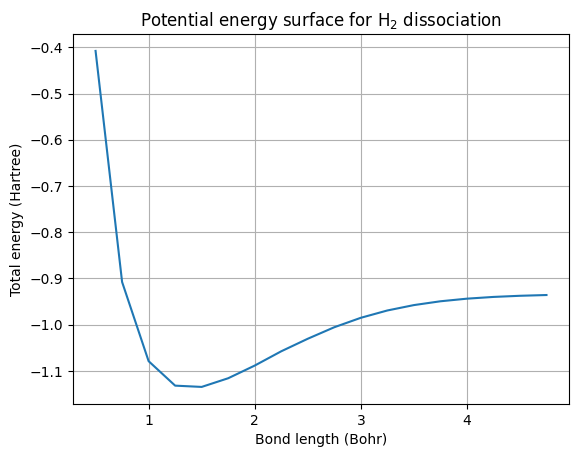

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()

This is the potential energy surface for the dissociation of a hydrogen
molecule into two hydrogen atoms. It is a numerical calculation of the
same type of plot that was illustrated in the beginning. In a diatomic
molecule such as $H_2$, it can be used to obtain the equilibrium bond
length --- the distance between the two atoms that minimizes the total
electronic energy. This is simply the minimum of the curve. We can also
obtain the bond dissociation energy, which is the difference in the
energy of the system when the atoms are far apart and the energy at
equilibrium. At sufficiently large separations, the atoms no longer form
a molecule, and the system is called \"dissociated\".

Let\'s use our results to compute the equilibrium bond length and the
bond dissociation energy:


In [ ]:
# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

The equilibrium bond length is 1.5 Bohrs
The bond dissociation energy is 0.198772 Hartrees


These estimates can be improved by using bigger basis sets and
extrapolating to the complete basis set limit. The calculations are of
course are subject to the grid size of interatomic distances considered.
The finer the grid size, the better the estimates.

::: {.note}
::: {.title}
Note
:::

Did you notice a trick we used to speed up the calculations? The
converged gate parameters for a particular geometry on the PES are used
as the initial guess for the calculation at the adjacent geometry. With
a better guess, the algorithm converges faster and we save considerable
time.
:::


Hydrogen Exchange Reaction
==========================

After studying a simple diatomic bond dissociation, we move to a
slightly more complicated case: a hydrogen exchange reaction.

$$H_2 + H \rightarrow H + H_2.$$

This reaction has a barrier, the [transition
state](https://en.wikipedia.org/wiki/Transition_state), that must be
crossed for the exchange of an atom to be complete. In this case, the
transition state corresponds to a specific linear arrangement of the
atoms where one $H-H$ bond is partially broken and the other $H-H$ bond
is partially formed. The molecular movie ⚛️🎥 below is an illustration of
the reaction trajectory. It depicts how the distance between the
hydrogen atoms changes as one bond is broken and another one is formed.
The path along which the reaction proceeds is known as the [reaction
coordinate](https://en.wikipedia.org/wiki/Reaction_coordinate).

![](/_static/demonstration_assets/vqe_bond_dissociation/h3_mol_movie.gif){.align-center
width="50.0%"}

In a minimal basis like STO-3G, this system consists of three electrons
in six spin molecular orbitals. This translates into a six-qubit
problem, for which the Hartree-Fock state is $|111000\rangle$. As there
is an unpaired electron, the spin multiplicity is equal to two and needs
to be specified, since it differs from the default value of one.


In [ ]:
symbols = ["H", "H", "H"]
multiplicity = 2

To build a potential energy surface for the hydrogen exchange, we fix
the positions of the outermost atoms, and change only the placement of
the middle atom. For this circuit, we employ all single and double
excitation gates, which can be conveniently done with the
`~.pennylane.templates.subroutines.AllSinglesDoubles`{.interpreted-text
role="class"} template. The rest of the procedure follows as before.


In [ ]:
from pennylane.templates import AllSinglesDoubles

energies = []
pes_point = 0

# get all the singles and doubles excitations, and Hartree-Fock state
electrons = 3
orbitals = 6
singles, doubles = qchem.excitations(electrons, orbitals)
hf = qml.qchem.hf_state(electrons, orbitals)


# loop to change reaction coordinate
r_range = np.arange(1.0, 3.0, 0.1)
for r in r_range:

    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r, 0.0, 0.0, 4.0])

    # We now specify the multiplicity
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, mult=multiplicity, method='pyscf')

    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=1.5)

    @qml.qnode(dev, interface='autograd')
    def circuit(parameters):
        AllSinglesDoubles(parameters, range(qubits), hf, singles, doubles)
        return qml.expval(H)  # we are interested in minimizing this expectation value

    params = np.zeros(len(singles) + len(doubles), requires_grad=True)

    if pes_point > 0:
        params = params_old

    prev_energy = 0.0

    for n in range(60):
        params, energy = opt.step_and_cost(circuit, params)
        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)

Once the calculation is complete, we can plot the resulting potential
energy surface.


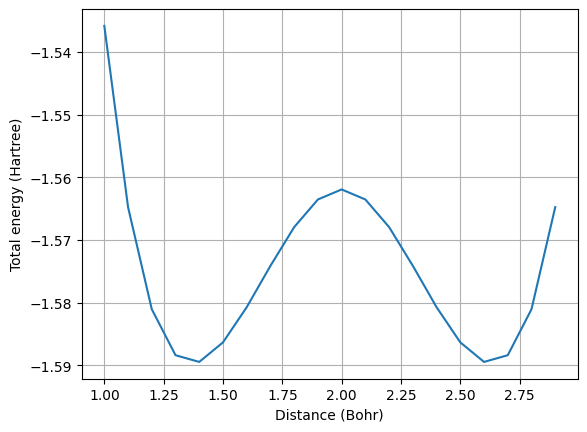

In [ ]:
fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Distance (Bohr)",
    ylabel="Total energy (Hartree)",
)
ax.grid()
plt.show()

The two minima in the curve represent the energy of the reactants and
products. The transition state is represented by the local maximum.
These are the configurations illustrated in the animation above.


Activation energy barriers and reaction rates
=============================================

The potential energy surfaces we computed so far can be leveraged for
other important tasks, such as computing activation energy barriers and
reaction rates. The activation energy barrier ( $E_{a}$) is defined as
the difference between the energy of the reactants and the energy of the
transition state.

$$E_{a} = E_{TS} - E_{R}.$$

This can be computed from the potential energy surface:


In [ ]:
# Energy of the reactants and products - two minima on the PES
e_eq1 = min(energies)
e_eq2 = min([x for x in energies if x != e_eq1])

idx1 = energies.index(e_eq1)
idx2 = energies.index(e_eq2)

# Transition state is the local maximum between reactant and products
idx_min = min(idx1, idx2)
idx_max = max(idx1, idx2)

# Transition state energy
energy_ts = max(energies[idx_min:idx_max])

# Activation energy
activation_energy = energy_ts - e_eq1

print(f"The activation energy is {activation_energy:.6f} Hartrees")

The reaction rate constant ($k$) has an exponential dependence on the
activation energy barrier, as shown in the [Arrhenius
equation](https://en.wikipedia.org/wiki/Arrhenius_equation) (Arrr!
🏴‍☠️):

$$k = Ae^{-{E_{a}}/k_BT},$$

where $k_B$ is the Boltzmann constant, $T$ is the temperature, and $A$
is a pre-exponential factor that can be determined empirically for each
reaction. Crucially, the rate at which a chemical reaction occurs
depends exponentially on the activation energy computed from the PES ---
this is a good reminder of the importance of performing highly-accurate
calculations in quantum chemistry!

For example, let\'s calculate the ratio of reaction rates when the
temperature is doubled. We have

$$\frac{k_2}{k_1}=\frac{Ae^{-{E_{a}}/k_B(2T)}}{Ae^{-{E_{a}}/k_BT}}=e^{E_a/2k_B T}.$$

We choose $T=300$ Kelvin, which is essentially room temperature. This
makes doubling the temperature roughly equivalent to the temperature
inside a pizza oven. We have


In [ ]:
# convert to joules
activation_energy *= 4.36e-18
# Boltzmann constant in Joules/Kelvin
k_B = 1.38e-23
# Temperature
T = 300

ratio = np.exp(activation_energy / (2 * k_B * T))

print(f"Ratio of reaction rates is {ratio:.0f}")

Doubling the temperature can increase the rate by a factor of almost two
million! For a similar reason, changing the activation energy can lead
to drastic changes in the reaction rates, which means we have to be
careful to compute it very accurately.

Conclusion
==========

We can learn how atoms combine to form different molecules by performing
experiments; this is the approach many of us learn as children by
playing with chemistry sets. However, a deeper quantitative
understanding of chemical reactions can be achieved by performing
theoretical simulations of the mechanisms for forming and breaking
bonds. This tutorial described how simple chemical reactions can be
simulated using quantum algorithms that reconstruct potential energy
surfaces, allowing us to identify reactants and products as minima of
the energy, and transition states as local maxima. These results can
then be used to calculate activation energies and reaction rates. The
goal (and challenge!) for quantum computing is to improve both hardware
and algorithms to reach the regime where providing accurate simulations
becomes intractable for existing methods. If successful, this quest will
allow us to understand the properties of quantum systems in ways that
have so far been out of reach.

References
==========

About the authors
=================
